In [ ]:
import re
import nltk
import os
import sys
import pandas as pd

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from pymystem3 import Mystem

import warnings

warnings.filterwarnings("ignore")

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics

RANDOM_STATE = 41825352
DATASET_URL = "https://storage.yandexcloud.net/cbr-press-release-classifier/cbr-press-releases.csv"

nltk.download("stopwords", quiet=True)

True

In [2]:
df = pd.read_csv(DATASET_URL, parse_dates=["date"])

df.set_index("date", inplace=True)
df.sort_values("date", inplace=True)

# исключаем последний релиз
last_release = df.tail(1)
df = df[:-1]

# разделяем данные на признаки и целевую переменную
X = df[["release", "inflation", "rate", "usd"]]
y = df["target_categorial"]

In [3]:
STOP_WORDS = set(stopwords.words("russian"))

mystem = Mystem()


def preprocessor(text):
    text = text.lower()
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)
    text = " ".join(mystem.lemmatize(text))
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text

In [4]:
# список экзогенных признаков
timeseries_features = ["inflation", "rate", "usd"]

# список лагов целевой переменной
target_lags = [f"lag{i}_target" for i in range(5)]

# добавляем лаги целевой переменной
for i in range(1, 4 + 1):
    X[f"lag{i}_target"] = y.shift(i)

# для всех экзогенных признаков
for feature in ["inflation", "rate", "usd"]:
    # добавляем рост
    X[f"growth_{feature}"] = X[feature] / X[feature].shift(1)
    timeseries_features.append(f"growth_{feature}")

copy_timeseries_features = timeseries_features.copy()

# для всех признаков добавляем лаги
for feature in copy_timeseries_features:
    for i in range(1, 4):
        X[f"lag{i}_{feature}"] = X[feature].shift(i)
        timeseries_features.append(f"lag{i}_{feature}")

# заполняем пропуски следующими значениями
X.bfill(inplace=True)

In [ ]:
preprocessor_svc = ColumnTransformer(
    [
        (
            "tf-idf",
            TfidfVectorizer(
                preprocessor=preprocessor, min_df=10, max_df=0.999255624327396
            ),
            0,
        )
    ]
)

selector_svc = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=179.60420717202715,
    max_iter=1000,
    random_state=RANDOM_STATE,
)

svc = Pipeline(
    [
        ("transform", preprocessor_svc),
        ("selector", SelectFromModel(selector_svc)),
        (
            "classifier",
            SVC(
                C=443.27906207757445,
                kernel="rbf",
                probability=True,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

preprocessor_timeseries = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), list(range(1, X.shape[1])))]
)

timeseries = Pipeline(
    steps=[
        ("preprocessor", preprocessor_timeseries),
        (
            "classifier",
            KNeighborsClassifier(
                n_neighbors=2,
                weights="distance",
                p=1,
                algorithm="brute",
            ),
        ),
    ]
)

preprocessor_knn = ColumnTransformer(
    [
        (
            "tf-idf",
            TfidfVectorizer(
                preprocessor=preprocessor, min_df=9, max_df=0.9758810938842265
            ),
            0,
        )
    ]
)

selector_knn = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=457.94328628621355,
    max_iter=1000,
    random_state=RANDOM_STATE,
)

knn = Pipeline(
    steps=[
        ("preprocessor", preprocessor_knn),
        ("selector", SelectFromModel(selector_knn)),
        (
            "classifier",
            KNeighborsClassifier(
                n_neighbors=1,
                weights="distance",
                p=1.993539588788783,
                metric="cosine",
                algorithm="brute",
            ),
        ),
    ]
)

preprocessor_forest = ColumnTransformer(
    [
        (
            "tf-idf",
            TfidfVectorizer(preprocessor=preprocessor, min_df=6, max_df=9),
            0,
        )
    ]
)

forest = Pipeline(
    steps=[
        ("preprocessor", preprocessor_forest),
        ("selector", PCA(n_components=27)),
        (
            "classifier",
            RandomForestClassifier(max_depth=9, random_state=RANDOM_STATE, n_jobs=-1),
        ),
    ]
)

# Создаем ансамбль моделей
ensemble = VotingClassifier(
    estimators=[
        ("svc", svc),
        ("timeseries", timeseries),
        ("knn", knn),
        ("forest", forest),
    ],
    voting="soft",
)  # 'soft' для вероятностей, 'hard' для предсказаний классов

In [6]:
ensemble

VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('transform',
                                               ColumnTransformer(transformers=[('tf-idf',
                                                                                TfidfVectorizer(max_df=0.999255624327396,
                                                                                                min_df=10,
                                                                                                preprocessor=<function preprocessor at 0x719cacfb4ea0>),
                                                                                0)])),
                                              ('selector',
                                               SelectFromModel(estimator=LogisticRegression(C=179.60420717202715,
                                                                                            max_iter=1000,
                                                                                            penalty='l1',
                                                                                            random_state=41825352,
                                                                                            solver...
                                                                    p=1.993539588788783,
                                                                    weights='distance'))])),
                             ('forest',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('tf-idf',
                                                                                TfidfVectorizer(max_df=9,
                                                                                                min_df=6,
                                                                                                preprocessor=<function preprocessor at 0x719cacfb4ea0>),
                                                                                0)])),
                                              ('selector',
                                               PCA(n_components=27)),
                                              ('classifier',
                                               RandomForestClassifier(max_depth=9,
                                                                      n_jobs=-1,
                                                                      random_state=41825352))]))],
                 voting='soft')

              precision    recall  f1-score   support

        -1.0       0.79      0.83      0.81        23
         0.0       0.64      0.62      0.63        26
         1.0       0.74      0.74      0.74        19

    accuracy                           0.72        68
   macro avg       0.72      0.73      0.72        68
weighted avg       0.72      0.72      0.72        68



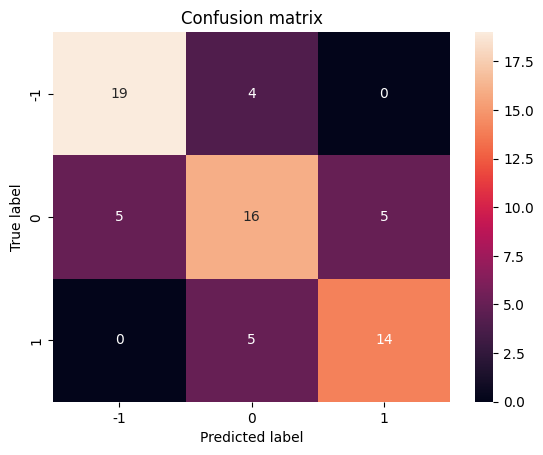

In [8]:
metrics, model = calc_metrics(X.values, y, ensemble, name="")

In [9]:
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
,0.720588,0.724268,0.726105,0.722836,0.80037,0.804861
